<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Électrocinétique
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Électrocinétique numérique | Transformée de Fourier discrète
             </div>
        </div>
    </div>
</div>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib inline

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique
##  Signal numérique
Un signal numérique est généralement le résultat d'une acquisition d'un signal physique par un transducteur, sur une durée fini $T_\text{mes}$. Mais il peut être très simplement généré numériquement à l'aide des `np.array` de la bibliothèque `numpy`.

&nbsp;
On va donc générer une liste d'instants `t`, d'une durée `Tmes` proportionelle à une période $T$, notée `T` dans le script python qui suit, contenant `Num` valeurs.

&nbsp; 
Le signal numérique sera une somme de sinusoïdes, périodique de période $T$ et sera codé dans une fonction `sin_per()` qui prendra pour argument l'array `t` ainsi qu'un réel `T`.

&nbsp;
On commence par tracer la fonction `sin_per` pour toute valeur de `Tmes = 5*T`.

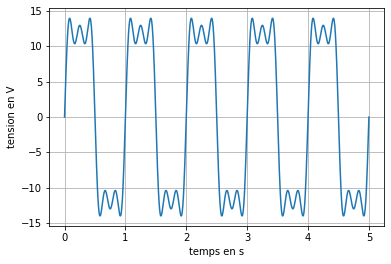

In [2]:
A = 15.
T = 1.
Tmes = 5*T
Num = 1000

t = np.linspace(0,Tmes,Num)

def sin_per(t, T):
    return A*np.sin(2*np.pi*t/T)+A/3*np.sin(2*np.pi*3*t/T)+A/5*np.sin(2*np.pi*5*t/T)

plt.figure()
plt.plot(t,sin_per(t,T))
plt.xlabel('temps en s')
plt.ylabel('tension en V')
plt.grid(True)
plt.show()

## Transformée de Fourier discrète
### Coefficients de Fourier
On a vu que tout signal $f:t\mapsto f(t)$, périodique de période $T$, pouvait se décomposer en une somme de fonctions sinusoïdales : 
$$f(t)=\sum_{k=0}^{+\infty}\alpha_k\cos\left(\dfrac{2\pi k}{T}t\right) + \sum_{k=0}^{+\infty}\beta_k\sin\left(\dfrac{2\pi k}{T}t\right)$$


&nbsp;
Les coefficients $\alpha_k$ et $\beta_k$ sont les coefficients de Fourier que l'on recherche. Dans l'exemple traité, il est évident que $\forall k, \alpha_k=0$ et que $\beta_0=0$, $\beta_1=15$, $\beta_3=5$ et $\beta_5=3$.</br>
Dans le cas général où $f:t\mapsto f(t)$ est le résultat d'une acquisition, et donc un signal a priori inconnu, on peut tirer parti des nombres complexes et ré-écrire cette relation sous la forme :
$$\underline{f}(t)=\sum_{k=-\infty}^{+\infty}\gamma_k\text{e}^{\text{j}\frac{2\pi k}{T}t}$$
où :
$$\gamma_k = \left\lbrace\begin{array}{ll}
\alpha_0 & \text{si }k=0 \\
\frac{1}{2}(\alpha_{-k}+\text{j}\beta_{-k}) & \text{si }k<0 \\
\frac{1}{2}(\alpha_{-k}-\text{j}\beta_k) & \text{si }k>0 \\
\end{array}\right.$$

&nbsp;
Il reste alors à extraire les diverses valeurs de $\gamma_k$ de la relation précédente. Pour y parvenir, on peut multiplier $\underline{f}(t)$ par $\text{e}^{-\text{j}\frac{2\pi k}{T}t}$ et l'intégrer sur une période.</br>
Pour toute valeur $k'\neq k$, l'intégrale est nulle, et on en déduit : 
$$\gamma_k=\dfrac{1}{T}\int_{t=0}^T f(t)\text{e}^{-\text{j}\frac{2\pi k}{T}t} \text{d}t$$

Numériquement l'intégrale peut se calculer par la méthode des trapèzes. On suppose que la fonction $f$ est décrite numériquement par une liste de `Num` valeurs discrètes `f=[f(0), f(1, ..., f(t_n), ..., f(T)]` où `t_n` est l'instant $t_n=\frac{n}{\text{Num}-1}T$.

&nbsp;
La relation précédente devient alors : 
$$\gamma_k=\dfrac{1}{N}\left(\dfrac{f(0)+f(T)}{2} + \sum_{n=1}^{N-1}f(t_n)\text{e}^{-\text{j}\frac{2\pi k t_n}{T}}\right) = \dfrac{1}{N}\left(\sum_{n=0}^{N-1}f(t_n)\text{e}^{-\text{j}\frac{2\pi k t_n}{T}}\right)$$
puisque $f(0)=f(T)$ par périodicité.

&nbsp;
En remarquant que les coefficients calculés au-delà de $\text{Num}/2$ sont identiques à ceux calculés avant, on peut limiter le calcul aux $\text{Num}/2$ premiers termes, ce qui est fait dans la fonction `dft` ci-dessous.

In [3]:
def dft(y):
    N=len(y)
    c=np.zeros(N//2+1, dtype=complex)
    for k in range(N//2+1):
        for n in range(N):
            c[k] += y[n]*np.exp(-2j*np.pi*n*k/N)/(N//2 +1)
    return c

Les coefficients de Fourier sont alors calculés correctement, mais il reste à afficher les fréquences associées à chaque valeur de $k$. Ces fréquences sont des multiples de la résolution fréquentielle $\Delta f=\frac{1}{T_\text{mes}}$. Il suffit alors de créer la liste de valeurs possibles de fréquences $\forall i\in[0,\frac{\text{Num}}{2}], f_i=i\frac{1}{T_\text{mes}}$, ce qui est fait dans la liste `freq_k` définie ci-dessous.

&nbsp;
On compare le résultat obtenu à celui fourni par la transformée de Fourier discrète de numpy : `np.fft.rfft()`. Cette dernière doit être normalisée de la même façon que la méthode que nous avons développée.

In [4]:
y = dft(sin_per(t,T))

y_numpy = np.fft.rfft(sin_per(t,T))/(Num//2+1)

freq_k = np.array([i/Tmes for i in range(len(y))])

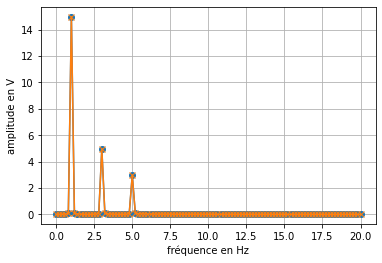

In [5]:
plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq_k[:Num//10+1],np.abs(y)[:Num//10+1],'-o')
plt.plot(freq_k[:Num//10+1],np.abs(y_numpy)[:Num//10+1],'-x')
plt.xlabel('fréquence en Hz')
plt.ylabel('amplitude en V')
plt.grid(True)
plt.show()

Les résultats sont en tous points comparables, les pics sont de fréquence et d'amplitude identiques et conformes à ceux attendus puisqu'on retrouve $f_1=1~\text{Hz}$ associé à l'amplitude 15, $f_3=3~\text{Hz}$ associé à l'amplitude 5 et $f_5=5~\text{Hz}$ associé à l'amplitude 3.

&nbsp;
On peut remarquer que la résolution fréquentielle, c'est-à-dire l'écart entre deux valeurs possibles de fréquences résolues, est $\Delta f = \frac{1}{5T}$ pour les deux approches. 

&nbsp;
La seule différence notable entre la fonction codée par nos soins, et la méthode `fft.rfft()` (<a href="https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html">doc.</a>) de `numpy` est le temps de calcul, comme le montre les tests ci-dessous.

In [6]:
%timeit y=dft(sin_per(t,T))

1.62 s ± 6.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit y2=np.fft.rfft(sin_per(t,T))/(Num//2+1)

45 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Échantillon non multiple d'une période.
Il est très peu probable que la durée d'une acquisition soit un multiple entier de la période du signal à analyser. Pourtant un écart, même minime, a des conséquences non négligeables sur le spectre obtenu.

&nbsp;
Pour s'en convaincre, on établit ci-dessous le spectre d'un même signal, l'un mesuré pendant exactement $T_\text{mes}=5T$, l'autre pendant $T_\text{mes}'=5,1T$ et on compare les spectres obtenus. Le nombre d'échantillons `Num` est laissé identique.

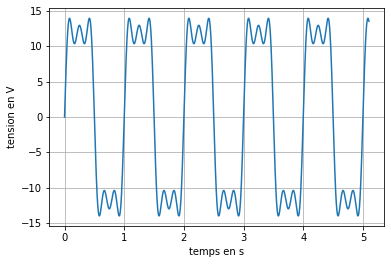

In [8]:
A = 15.
T = 1.
Num = 1000

Tmes_2 = 5.1*T

t_2 = np.linspace(0,Tmes_2,Num)

plt.figure()
plt.plot(t_2,sin_per(t_2,T))
plt.xlabel('temps en s')
plt.ylabel('tension en V')
plt.grid(True)
plt.show()

On cacule le spectre de ce même signal échantillonné sur une durée légèrement plus longue et on le compare à celui calculé sur les cinq périodes.

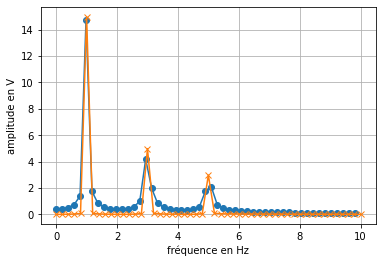

In [9]:
# Spectre du signal calculé sur 5 périodes
y = np.fft.rfft(sin_per(t,T))/(Num//2+1)
freq_k = np.array([i/Tmes for i in range(len(y))])

# Spectre du signal calculé sur 50/9=5,55 périodes
y_2 = np.fft.rfft(sin_per(t_2,T))/(Num//2+1)
freq_k_2 = np.array([i/Tmes_2 for i in range(len(y_2))])


plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq_k_2[:Num//20+1],np.abs(y_2)[:Num//20+1],'-o')
plt.plot(freq_k[:Num//20+1],np.abs(y)[:Num//20+1],'-x')
plt.xlabel('fréquence en Hz')
plt.ylabel('amplitude en V')
plt.grid(True)
plt.show()

Les divers pics fréquentiels sont correctement calculés, mais un ensemble de fréquences intermédiaires sont apparues et les amplitudes sont atténuées.

&nbsp;
On pourra faire varier la durée de `Tmes_2` pour se convaincre de l'importance de caler, autant que possible la durée d'acquisition avec la période du fondamental.

### Rôle de la durée d'acquisition
Au-delà de la "synchronisation" de la durée d'acquisition et de la période fondamentale, la durée de l'acquisition a également un rôle important puisqu'elle augmente ou diminue la résolution fréquentielle.

&nbsp;
Dans l'exemple ci-dessous on multiplie la durée de l'acquisition, et le nombre d'échantillons par 10, et on compare les spectres obtenus avec les durées $5T$ (qui sert de référence), $\frac{50T}{9}$ et $\frac{500T}{9}$.

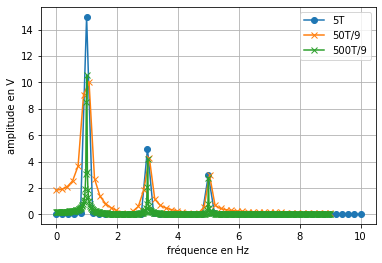

In [10]:
A = 15.
T = 1.
Num = 1000

t = np.linspace(0,5*T,Num)
t_2 = np.linspace(0,50*T/9,Num*10)
t_3 = np.linspace(0,500*T/9,Num*100)

# Spectre du signal calculé sur 5 périodes
y = np.fft.rfft(sin_per(t,T))/(Num//2+1)
freq_k = np.array([i/np.max(t) for i in range(len(y))])

# Spectre du signal calculé sur 50/9=5,55 périodes
y_2 = np.fft.rfft(sin_per(t_2,T))/(Num*10//2+1)
freq_k_2 = np.array([i/np.max(t_2) for i in range(len(y_2))])

# Spectre du signal calculé sur 500/9=55,55 périodes
y_3 = np.fft.rfft(sin_per(t_3,T))/(Num*100//2+1)
freq_k_3 = np.array([i/np.max(t_3) for i in range(len(y_3))])


plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq_k[:Num//20+1],np.abs(y)[:Num//20+1],'-o', label='5T')
plt.plot(freq_k_2[:Num//20+1],np.abs(y_2)[:Num//20+1],'-x', label='50T/9')
plt.plot(freq_k_3[:Num*10//20+1],np.abs(y_3)[:Num*10//20+1],'-x', label='500T/9')
plt.xlabel('fréquence en Hz')
plt.ylabel('amplitude en V')
plt.legend()
plt.grid(True)
plt.show()

Les fréquences parasites sont notablement amorties, la résolution spectrale est améliorée mais l'amplitude calculée n'est toujours pas la bonne.

### Fenêtrage (hors-programme)
Une grande partie des fréquences parasites provient de la méthode de calcul de la transformée de Fourier qui s'appuie sur une propriété de périodicité du signal acquis qui n'est pas vérifiée.

&nbsp;
On peut "forcer" cette périodicité en annulant la valeur du signal acquis sur les premiers et derniers instants de l'acquisition, ou en appliquant des fonctions de lissage vers $0$ au signal acquis. C'est ce que fait par exemple la fonction de Hanning (voir <a href="https://numpy.org/doc/stable/reference/generated/numpy.hanning.html">doc.</a> et <a href="https://en.wikipedia.org/wiki/Window_function">Wikipédia</a>) que l'on superpose au signal de durée $5T$ pour comprendre son rôle.

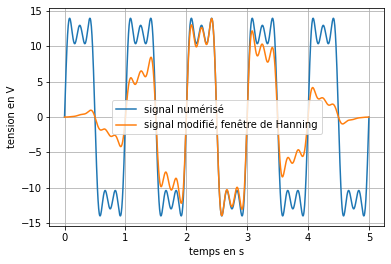

In [11]:
A = 15.
T = 1.
Tmes = 5*T
Num = 1000

t = np.linspace(0,Tmes,Num)

def sin_per(t, T):
    return A*np.sin(2*np.pi*t/T)+A/3*np.sin(2*np.pi*3*t/T)+A/5*np.sin(2*np.pi*5*t/T)

plt.figure()
plt.plot(t,sin_per(t,T), label="signal numérisé")
plt.plot(t,np.hanning(Num)*sin_per(t,T),label="signal modifié, fenêtre de Hanning")
plt.xlabel('temps en s')
plt.ylabel('tension en V')
plt.legend()
plt.grid(True)
plt.show()

On peut alors procéder à nouveau au calcul du spectre sur le nouveau signal artificiellement périodisé.


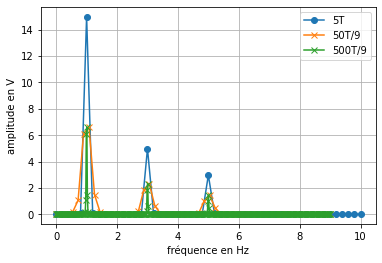

In [12]:
A = 15.
T = 1.
Num = 1000

t = np.linspace(0,5*T,Num)
t_2 = np.linspace(0,50*T/9,Num*10)
t_3 = np.linspace(0,500*T/9,Num*100)

# Spectre du signal calculé sur 5 périodes
y = np.fft.rfft(sin_per(t,T))/(Num//2+1)
freq_k = np.array([i/np.max(t) for i in range(len(y))])

# Spectre du signal calculé sur 50/9=5,55 périodes
y_2 = np.fft.rfft(np.hanning(Num*10)*sin_per(t_2,T))/(Num*10//2+1)
freq_k_2 = np.array([i/np.max(t_2) for i in range(len(y_2))])

# Spectre du signal calculé sur 500/9=55,55 périodes
y_3 = np.fft.rfft(np.hanning(Num*100)*sin_per(t_3,T))/(Num*100//2+1)
freq_k_3 = np.array([i/np.max(t_3) for i in range(len(y_3))])


plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq_k[:Num//20+1],np.abs(y)[:Num//20+1],'-o', label='5T')
plt.plot(freq_k_2[:Num//20+1],np.abs(y_2)[:Num//20+1],'-x', label='50T/9')
plt.plot(freq_k_3[:Num*10//20+1],np.abs(y_3)[:Num*10//20+1],'-x', label='500T/9')
plt.xlabel('fréquence en Hz')
plt.ylabel('amplitude en V')
plt.legend()
plt.grid(True)
plt.show()

Les fréquences parasites, présentes entre les pics, ont effectivement disparues, mais l'amplitude mesurée est notablement sous évaluée. Les proportions entre amplitude des pics sont cependant conservées.